# DGM architecture code in PyTorch
The DGM feedforward model.

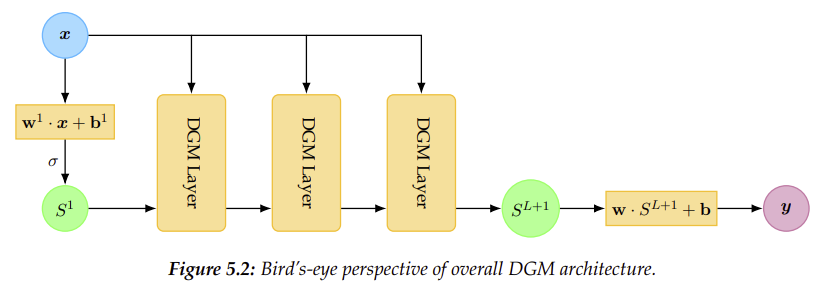

The inside of each DGM layer:

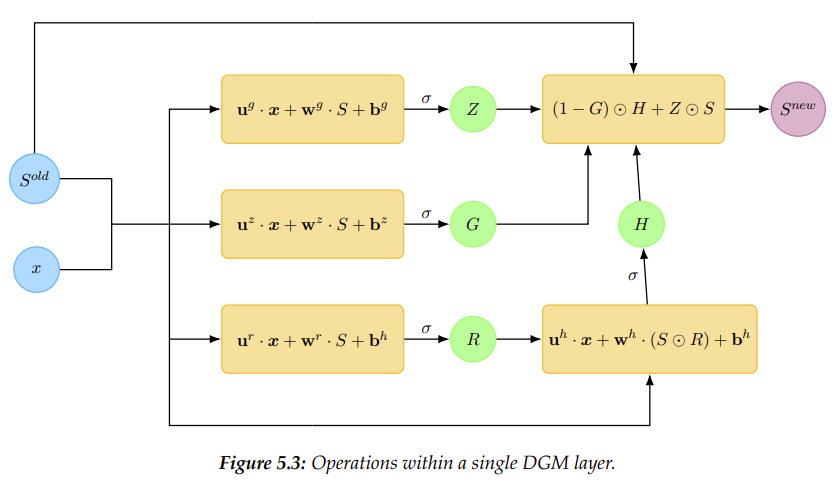

Mathematical model:

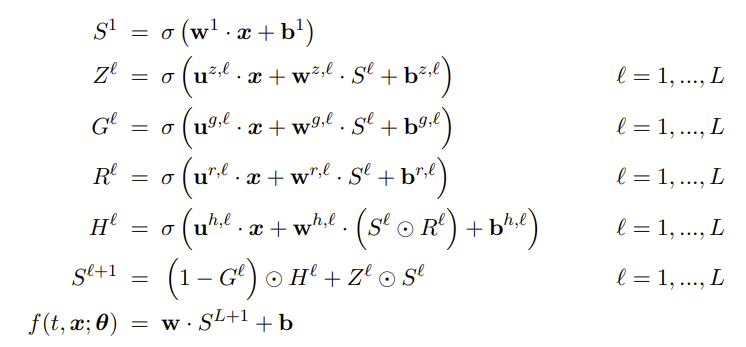

In [1]:
import torch
import torch.nn as nn # includes all models : Base class for all neural network modules.  # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
import numpy as np
from torch.nn.utils import weight_norm as WN # weight normalisation

In [2]:
torch.cuda.get_device_name(0)
!nvidia-smi

Tue Aug 16 16:47:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:03:00.0  On |                    0 |
| 30%   37C    P8    25W / 230W |    447MiB / 23028MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class DGMLayer(nn.Module):
    """
    Implements a single DGM layer.
    
    Parameters:
    -----------
    Primary Inputs:
    ---------------
    x : The training dataset
    S : Output from the previous layer
    
    Secondary Inputs:
    -----------------    
    weight_norm: bool = True
        Use weight norm on fully connected layers.
    d : int
        input dimension
    layer_size : int
        layer width
        
    Outputs:
    --------
    S : input for the next layer 
    
    Intermediate variables:
    -----------------------
    Z, G, R, H : Hidden layers
    Ug, Wg, Uz, Wz, Ur, Wr, Uh, Wh: associated weight matrices
    """
    
    def __init__(self, d_in, layer_size, sigma, weight_norm: bool = False):
        super().__init__()

        """
        wn : function returns decoupled weight tensor # https://pytorch.org/docs/stable/generated/torch.nn.utils.weight_norm.html
            A link for better understanding: https://stackoverflow.com/a/62214199/14598633
        """

        wn = WN if weight_norm else lambda x:x # function to do weighted norm of the weight tensor if enabled
        self.activation = nn.Tanh()   # Activation function
        ## Define 8 weights matrices
        
        # nn.Linear() automatically creates dimensions for the weights # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.Uz = wn(nn.Linear(d_in, layer_size, bias=False)).to(device)
        self.Ug = wn(nn.Linear(d_in, layer_size, bias=False)).to(device)
        self.Ur = wn(nn.Linear(d_in, layer_size, bias=False)).to(device)
        self.Uh = wn(nn.Linear(d_in, layer_size, bias=False)).to(device)
        
        self.Wz = wn(nn.Linear(layer_size, layer_size)).to(device)
        self.Wg = wn(nn.Linear(layer_size, layer_size)).to(device)
        self.Wr = wn(nn.Linear(layer_size, layer_size)).to(device)
        self.Wh = wn(nn.Linear(layer_size, layer_size)).to(device)
        
      
        

    def forward(self, SX):
        S, X = SX
        Z = self.activation(self.Uz(X) + self.Wz(S))
        G = self.activation(self.Ug(X) + self.Wg(S))
        R = self.activation(self.Ur(X) + self.Wr(S))
        H = self.activation(self.Uh(X) + self.Wh(S*R))
        S = (1-G)*H + Z*S

        return S, X

# def _set_convert(flag):
#     if flag: return lambda X: X[0]
#     return lambda X: torch.stack(X, -1)

In [5]:
class DGMArch(nn.Module):
    """
    Parameters
    ----------
    Primary Inputs:
    ---------------
    x : The training dataset
        
    Outputs:
    --------
    y : The predicted output 
    
    Intermediate variables:
    -----------------------
    S(L), S(L+1), DGM layer : Hidden layers
    W1, W: associated weight matrices
    
    Secondary Inputs:
    -----------------
    d_in : int
        Input dimension of the problem
    d_out : int
        Outpuut dimension of the problem
    layer_size: int = 512
        Layer size/ number of neurons for each DGM layer
    nr_layers:: int = 6
        Number of hidden layers
    skip_connections : bool = False
        If true then apply skip connections every 2 hidden layers
    activation_fn: layers.Activation = layers.Activation.SILU
        Activation function
    adaptive_activation: bool = False : TODO
        If True then use an adaptive activation funtion
    """
    
    def __init__(
        self,
        d_in, # input and output dimension of the problem
        d_out,
        layer_size: int = 512,
        skip_connections : bool = False, # TODO
        activation_fn = nn.SiLU,
        adaptive_activation: bool = False,
        weight_norm: bool = False,
        as_array=True,
        nr_layers=1,
    ) -> 'Network Initialised':  # 
        super().__init__() #call __init__ from parent class to initialise the torch.nn.Module
        
        # TDOD: adaptive activation
        if adaptive_activation:
            activation_par = nn.Parameter(torch.ones(1))
        else:
            activation_par = None
        
        wn = WN if weight_norm else lambda x: x  # function to do weighted norm of the weight tensor if enabled
        self.activation = nn.Tanh()   # Activation function
        
        self.W0 = wn(nn.Linear(d_in, layer_size)).to(device) # w_1 in first figure just after the input
        self.W1 = wn(nn.Linear(layer_size, d_out)).to(device) # w in the first figure just after the S(L+1)
        #self._convert = _set_convert(as_array)
        
        self.layers = []
                
        for l in range(nr_layers):
            self.layers.append(DGMLayer(d_in, layer_size, activation_fn, weight_norm)) # creates one DGM cell
            
        # difference betw2een nn.Sequential and nn.Module: https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463/9
        # basically, nn.Sequential is more tailored.
        self.layers = nn.Sequential(*self.layers) # for the last layer  # pass layers to nn.Sequential
        
    def forward(self, X):
        X = torch.t(X) # transpose
        S = self.activation(self.W0(X))
        S,_ = self.layers((S, X))
        return self.W1(S).squeeze_(-1)
        
        
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        

In [6]:
# Input arrays
inputs = np.arange(0,10+2,2)[:, None]
output = np.array([5])[:, None] 

In [7]:
# creating tensors
input_tensor = torch.from_numpy(inputs).float().to(device)
output_tensor = torch.from_numpy(output).float().to(device)

In [8]:
len(input_tensor)

6

In [9]:
DGM_model = DGMArch(len(input_tensor), len(output_tensor))

In [10]:
DGM_model.__init__.__annotations__

{'layer_size': int,
 'skip_connections': bool,
 'adaptive_activation': bool,
 'weight_norm': bool,
 'return': 'Network Initialised'}

# Testing forward prop

In [11]:
DGM_model.forward(input_tensor)

tensor([-0.7891], device='cuda:0', grad_fn=<SqueezeBackward3>)

In [12]:
DGM_model.weight

AttributeError: 'DGMArch' object has no attribute 'weight'

In [99]:
list(DGM_model.parameters())

[Parameter containing:
 tensor([[-0.0527, -0.0365, -0.0489, -0.0054, -0.1031, -0.0848],
         [-0.0567,  0.0191,  0.0114,  0.0002,  0.0678,  0.0536],
         [-0.0515, -0.0992,  0.0797,  0.0656,  0.0056,  0.0276],
         ...,
         [ 0.0748, -0.1033,  0.0377, -0.0030,  0.1062,  0.1057],
         [-0.0843, -0.0270, -0.0139,  0.0008, -0.0453, -0.0056],
         [ 0.0199,  0.0441, -0.0927, -0.0450,  0.0522,  0.0469]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 